(binimial-reg-notebook)=
# Regressione binomiale

Questo capitolo è dedicato alla regressione binomiale, un tipo specifico di analisi che viene utilizzata quando si hanno molteplici proporzioni di successi su $n$ prove.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Regressione Binomiale

Nel contesto della regressione binomiale, ci occupiamo di dati espressi attraverso frequenze multiple, come "3 successi su 7 tentativi". Il modello per questo tipo di regressione è definito come:

$$
y_i \sim \text{Binomiale}(n, p_i)
$$

dove:
- $ y_i $: indica il numero di successi;
- $ n $: rappresenta il numero totale di tentativi;
- $ p_i $: denota la probabilità di successo per l'i-esima osservazione.

L'obiettivo principale è di formulare una strategia per stimare i valori di $ p_i $ impiegando le variabili indipendenti a nostra disposizione. Questo obiettivo può essere raggiunto attraverso l'equazione:

$$
p_i = \text{InverseLogit}(\beta_0 + \beta_1 \cdot x_i)
$$

In questa formula:
- $ \beta_0 $ e $ \beta_1 $ sono i parametri che intendiamo stimare;
- $ x_i $ rappresenta la variabile indipendente o predittore;
- La funzione $\textit{InverseLogit}$, anche conosciuta come funzione logistica inversa, è definita come $\text{InverseLogit}(x) = \frac{1}{1 + e^{-x}}$, ed è utilizzata per trasformare un valore $x$, che può assumere qualsiasi valore reale, in un valore compreso tra 0 e 1, rendendolo interpretabile come una probabilità.

Proseguendo con un approccio bayesiano, è necessario integrare ulteriormente le credenze priori relative ai parametri $ \beta $ al fine di adattare il modello basandosi sui dati osservati.

## Un esempio concreto

Seguiamo il tutorial fornito sul sito ufficiale di PyMC e generiamo dei dati sintetici.

In [3]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})
display(data)

,x,y
0,-10.000000,0
1,-8.965517,0
2,-7.931034,2
3,-6.896552,3
4,-5.862069,3
5,-4.827586,4
6,-3.793103,7
7,-2.758621,6
8,-1.724138,9
9,-0.689655,9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


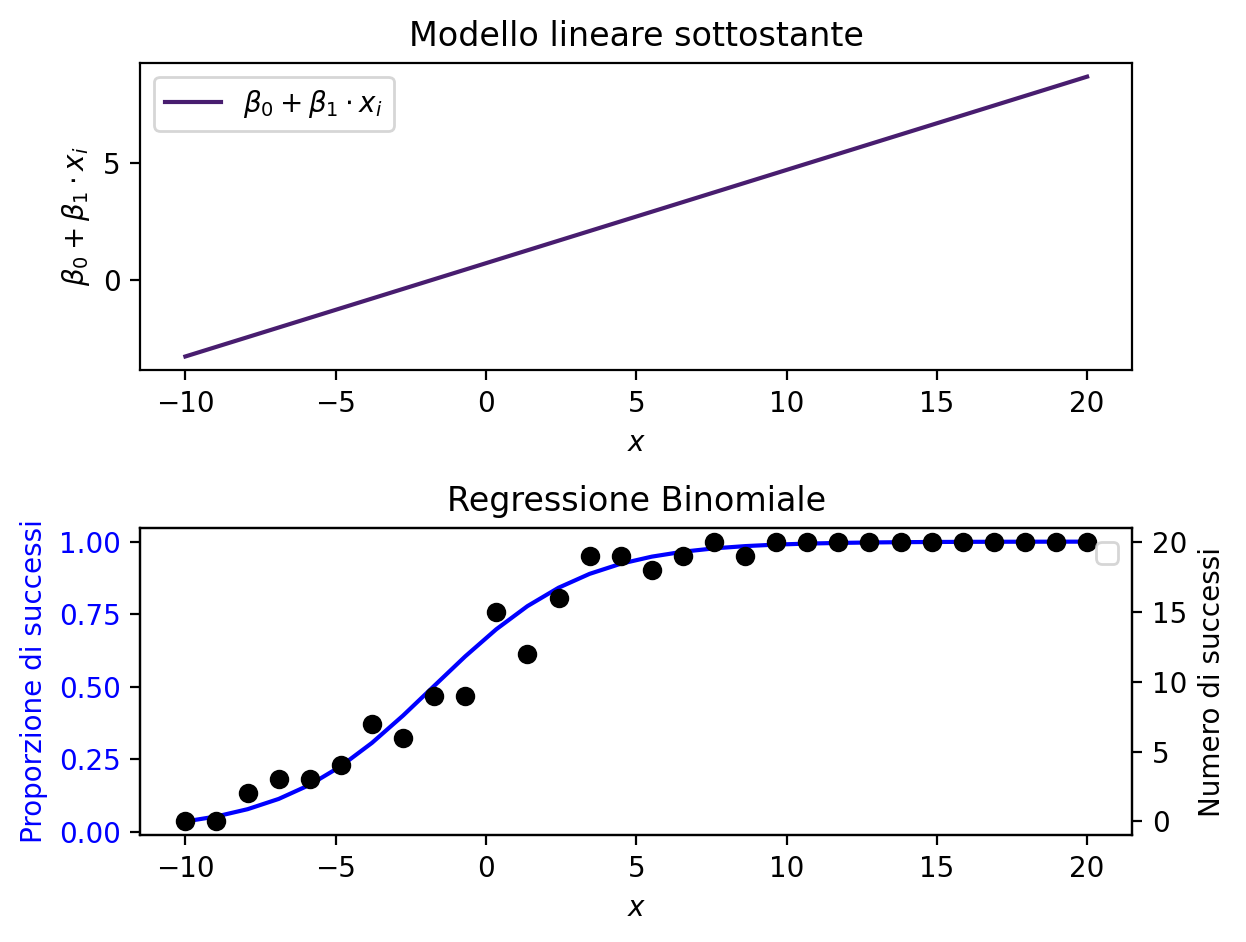

In [4]:
# Grafico del modello lineare sottostante
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(x, mu_true, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("$x$")
plt.ylabel(r"$\beta_0 + \beta_1 \cdot x_i$")
plt.title("Modello lineare sottostante")
plt.legend()

# Grafico della Regressione Binomiale
plt.subplot(2, 1, 2)
plt.plot(x, p_true, label=r"$g^{-1}(\beta_0 + \beta_1 \cdot x_i)$", color="b")
plt.ylabel("Proporzione di successi", color="b")
plt.tick_params(axis="y", labelcolor="b")
plt.xlabel("$x$")
plt.title("Regressione Binomiale")

# get y-axes to line up
y_buffer = 1

# Secondo asse y per il numero di successi
plt2 = plt.twinx()
plt2.scatter(x, y, color="k")
plt2.set_ylabel("Numero di successi")
plt2.set_ylim([-y_buffer, n + y_buffer])

plt.legend()
plt.tight_layout()
plt.show()

Il pannello superiore mostra il modello lineare nella sua forma non trasformata. Come si può osservare, questo modello lineare genera valori che escono dall'intervallo [0, 1], sottolineando quindi la necessità di una funzione di collegamento inversa. Questa funzione ha il compito di mappare i valori dal dominio dei numeri reali all'intervallo [0, 1]. Come abbiamo visto, questa trasformazione è realizzata mediante la funzione logistica inversa, anche conosciuta come funzione sigmoide logistica.

## PyMC

Iniziamo definendo un dizionario chiamato `coords` che sarà utilizzato nel modello PyMC. Nel contesto di PyMC, `coords` viene utilizzato per definire un "spazio di coordinate" per il  modello, che è un modo per tenere traccia delle dimensioni dei dati. In pratica, permette di associare nomi umanamente leggibili alle dimensioni dell'array di dati. Dopo aver definito il dizionario `coords`, quando vengono definite le variabili aleatorie e deterministe nel modello, è possibile fare riferimento alle chiavi in `coords` per specificare le dimensioni delle variabili.

In [13]:
coords = {"observation": data.index.values}
print(coords)

{'observation': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}


Procediamo ora con la definizione del modello di regressione binomiale tramite l'uso di PyMC.

In [14]:
with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.ConstantData("x", data["x"], dims="observation")
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", sigma=1)
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

Ecco un'analisi passo per passo di ciascuna parte del modello:

```python
with pm.Model(coords=coords) as binomial_regression_model:
```
Qui stiamo iniziando a definire il nostro modello PyMC, specificando che le coordinate del nostro modello saranno basate sulle coordinate che abbiamo definito in precedenza.

```python
    x = pm.ConstantData("x", data["x"], dims="observation")
```
In questa riga, stiamo definendo una variabile `x` che conterrà i dati osservati per la variabile indipendente, presi dalla colonna "x" del dataframe di dati.

```python
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
```
Qui stiamo definendo le distribuzioni priori per i nostri parametri di regressione, $\beta_0$ e $\beta_1$. Entrambi sono definiti come distribuzioni normali con una media ($\mu$) di 0 e una deviazione standard ($\sigma$) di 1.

```python
    # linear model
    mu = beta0 + beta1 * x
```
Questa è la parte centrale del nostro modello di regressione, dove definiamo la relazione lineare tra la variabile dipendente e la variabile indipendente, usando i parametri di regressione che stiamo cercando di stimare.

```python
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
```
Qui stiamo trasformando il modello lineare in una probabilità $ p $, usando la funzione logistica inversa (o invlogit) per garantire che i valori stimati siano compresi tra 0 e 1.

```python
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")
```
Infine, definiamo la funzione di verosimiglianza del modello come una distribuzione binomiale. La variabile dipendente $ y $ (i dati osservati) segue una distribuzione binomiale con $ n $ tentativi e una probabilità di successo $ p $ che è definita dal modello di regressione.

Generiamo il DAG del modello.

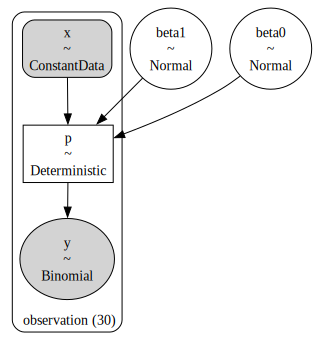

In [21]:
pm.model_to_graphviz(binomial_regression_model)

Eseguiamo il campionamento.

In [15]:
with binomial_regression_model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:03.193653
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 639.75it/s]


Sampling time =  0:00:03.317585
Transforming variables...
Transformation time =  0:00:00.108526
Computing Log Likelihood...
Log Likelihood time =  0:00:00.828905


L'argomento `idata_kwargs={"log_likelihood": True}` indica che desideriamo che il logaritmo della funzione di verosimiglianza (log-likelihood) sia calcolato e salvato insieme ai risultati del campionamento. Il log-likelihood è una misura di quanto bene il tuo modello spiega i dati osservati, e viene usato per la diagnostica del modello e per il confronto tra diversi modelli. 

Esaminiamo le distribuzioni a posteriori dei parametri.

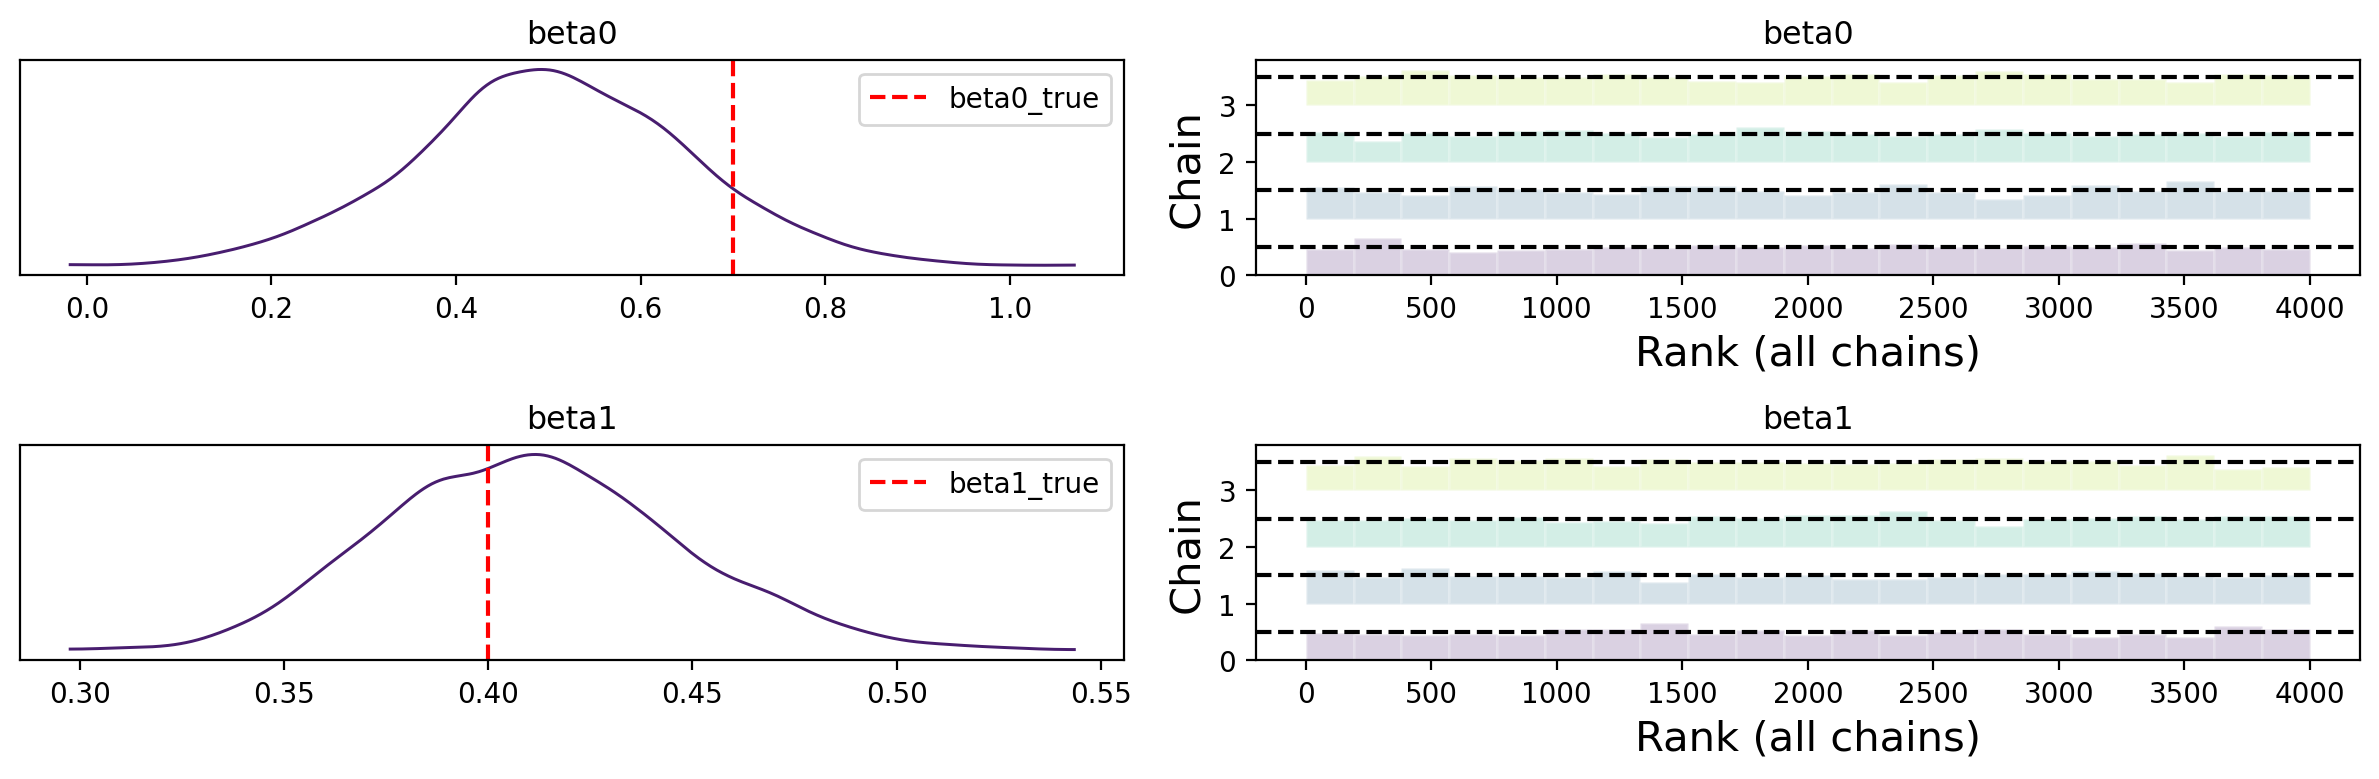

In [16]:
axes = az.plot_trace(idata, combined=True, kind="rank_bars", var_names=["beta0", "beta1"])

# Aggiungi una linea verticale per beta0_true al pannello della densità del kernel per beta0
axes[0][0].axvline(beta0_true, color='r', linestyle='--', label='beta0_true')
axes[0][0].legend()

# Aggiungi una linea verticale per beta1_true al pannello della densità del kernel per beta1
axes[1][0].axvline(beta1_true, color='r', linestyle='--', label='beta1_true')
axes[1][0].legend()

plt.tight_layout()

In [17]:
az.summary(idata, var_names=["beta0", "beta1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.503,0.148,0.220,0.786,0.003,0.002,2754.0,2359.0,1.0
beta1,0.411,0.036,0.349,0.483,0.001,0.001,2388.0,2585.0,1.0


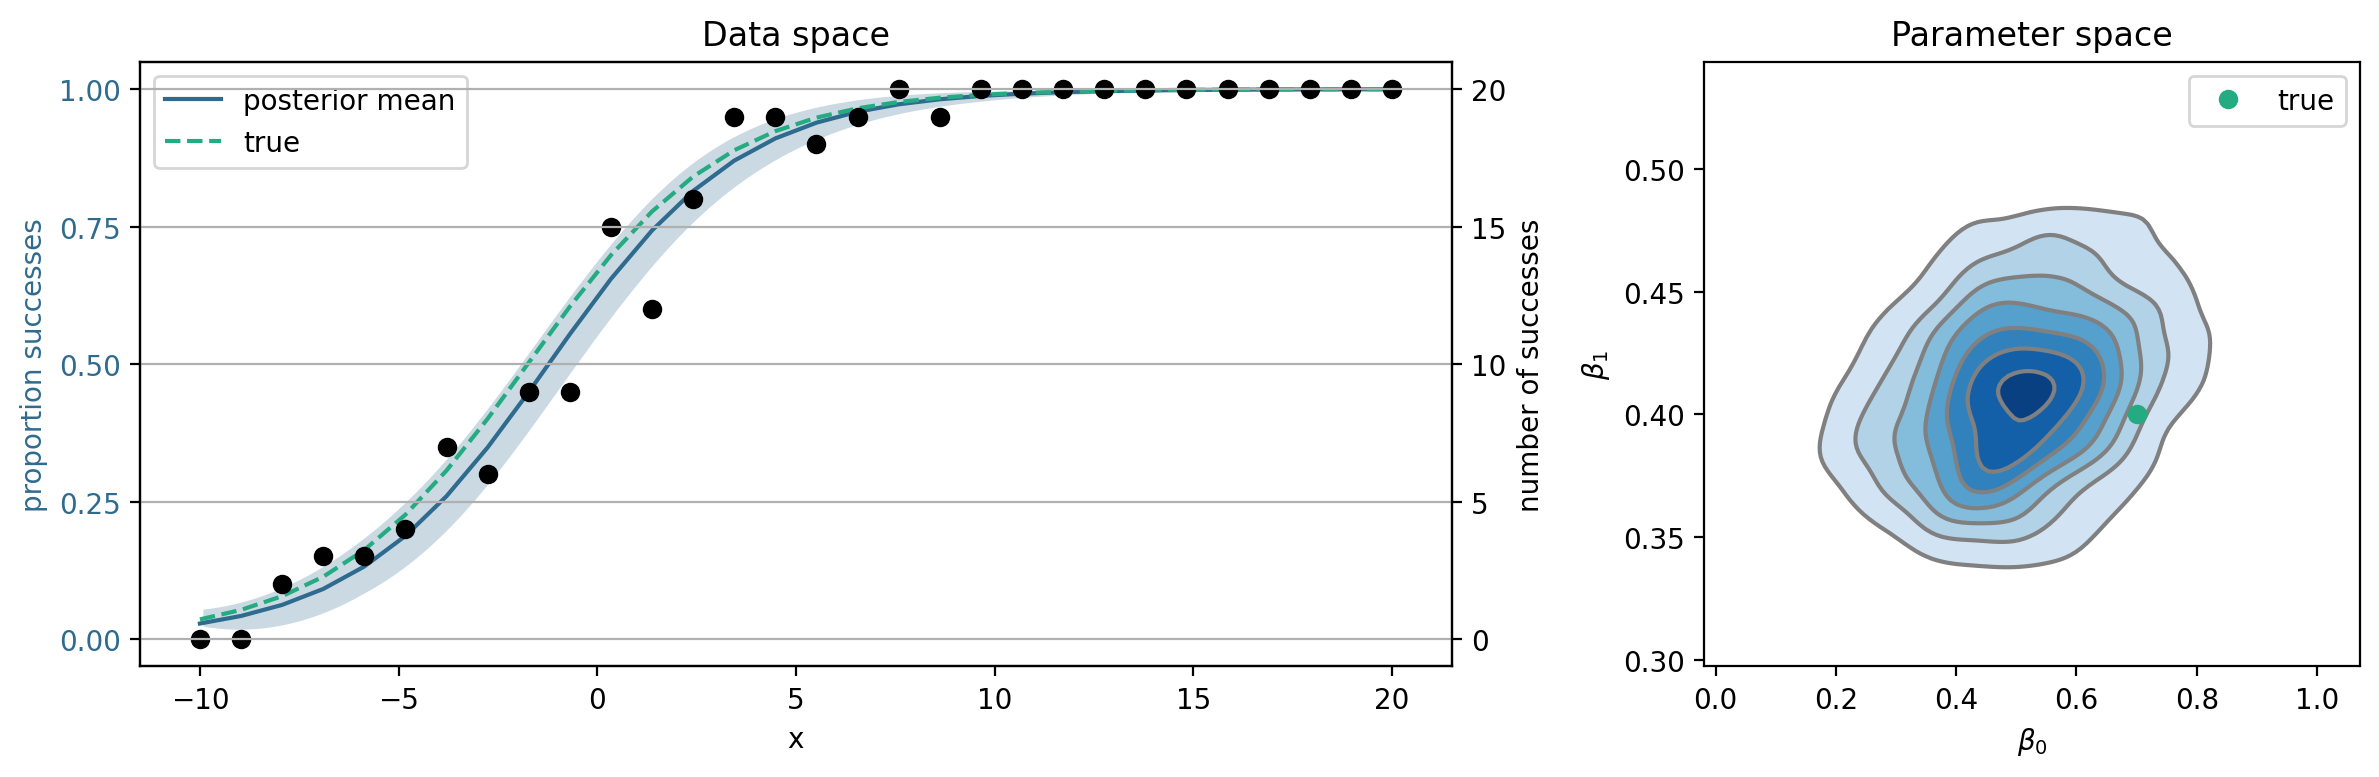

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True)
plt.tight_layout()

Il pannello di sinistra mostra la media posteriore (rappresentata dalla linea continua) e gli intervalli di credibilità al 95% (rappresentati dalla regione ombreggiata). Poiché stiamo lavorando con dati simulati, conosciamo il vero modello generativo dei dati. Pertanto, possiamo notare che la media posteriore si confronta favorevolmente con il modello vero e proprio che ha generato i dati.

Questo è confermato anche dalla distribuzione posteriore nello spazio dei parametri (pannello di destra), la quale si allinea bene con i parametri veri del modello generativo dei dati.

## Bambi

Replichiamo l'analisi precendente usando Bambi che ci consente di specificare il modello usando una sintassi semplificata.

Aggiungiamo ai dati la variabile `n` che corrisponde al numero di prove.

In [5]:
data["n"] = 20
data.head()

,x,y,n
0,-10.000000,0,20
1,-8.965517,0,20
2,-7.931034,2,20
3,-6.896552,3,20
4,-5.862069,3,20


Definiamo le stesse distribuzioni a priori usate in precedenza con PyMC.

In [6]:
# Definire i prior per beta0 e beta1
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "x": bmb.Prior("Normal", mu=0, sigma=1),
}

Specifichiamo la struttura del nostro modello di regressione binomiale utilizzando la sintassi richiesta dalla libreria Bambi.

In [7]:
formula = "p(y, n) ~ x"

Eseguiamo il campionamento. Si noti che abbiamo specificato la famiglia distributiva 

In [8]:
model_logit = bmb.Model(formula, data, family="binomial", priors=priors)

Nell'istruzione precedente creiamo un modello di regressione utilizzando la funzione `Model` dalla libreria Bambi (`bmb`). Vediamo in dettaglio cosa fa ogni argomento:

1. `formula`: Una stringa che specifica la formula del modello che vogliamo adattare. La formula descrive la relazione tra la variabile dipendente e la variabile indipendente.
2. `data`: Il dataset che intendiamo utilizzare per adattare il modello, il quale contiene tutte le variabili menzionate nella formula.
3. `family`: Questo argomento specifica la distribuzione della variabile di risposta, che in questo caso è impostata come "binomial". In questo modello, la variabile di risposta corrisponde al numero di successi che abbiamo osservato in 20 tentativi, e il modello userà la funzione logit per legare questa variabile di risposta alla variabile indipendente.
4. `priors=priors`: Questo argomento spefifica le distribuzioni a priori per i parametri del modello.

Esaminiamo il modello che abbiamo specificato.

In [9]:
model_logit

       Formula: p(y, n) ~ x
        Family: binomial
          Link: p = logit
  Observations: 30
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            x ~ Normal(mu: 0.0, sigma: 1.0)

Eseguiamo il processo di campionamento MCMC per ottenere una serie di campioni dalla distribuzione a posteriori dei parametri del modello.

In [10]:
fitted = model_logit.fit(method="nuts_numpyro")

Compiling...
Compilation time =  0:00:05.089836
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 605.55it/s]


Sampling time =  0:00:03.723397
Transforming variables...
Transformation time =  0:00:00.006590


Otteniamo un sommario della distribuzione a posteriori dei parametri del modello.

In [11]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.449,0.142,0.175,0.713,0.003,0.002,2729.0,2498.0,1.0
x,0.392,0.034,0.333,0.461,0.001,0.001,1184.0,1458.0,1.0


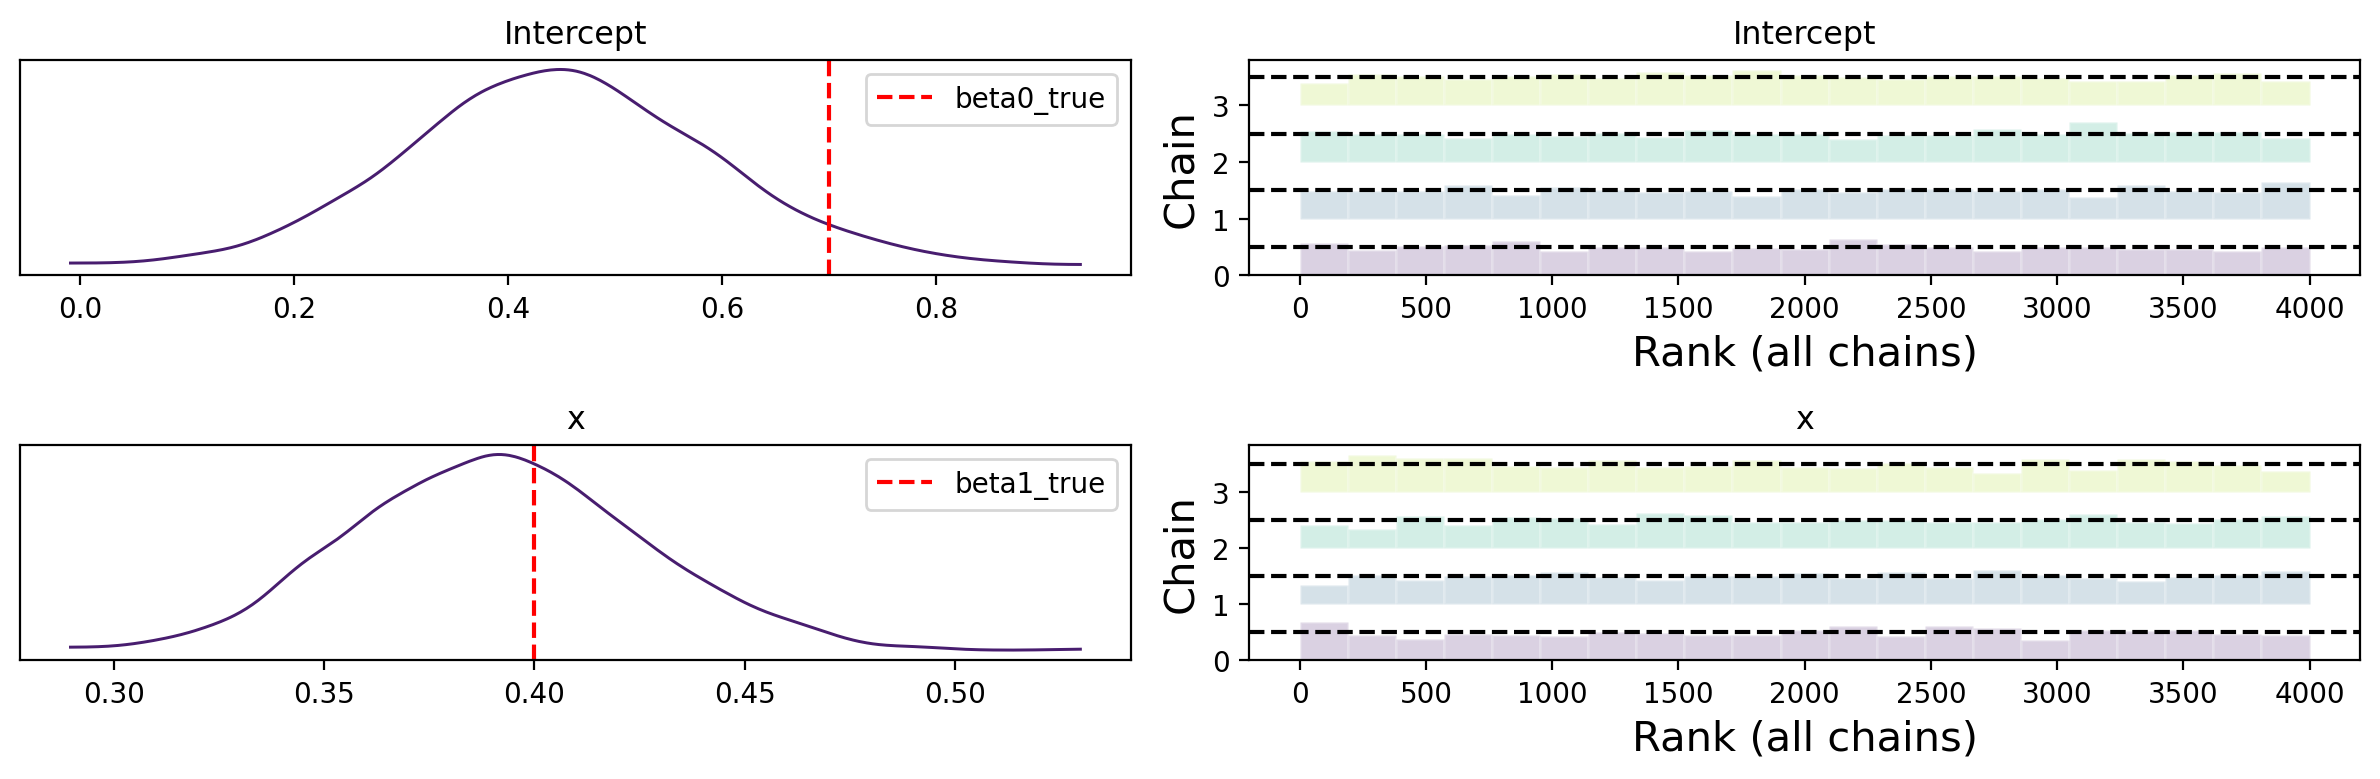

In [12]:
axes = az.plot_trace(fitted, combined=True, kind="rank_bars", var_names=["Intercept", "x"])

# Aggiungi una linea verticale per beta0_true al pannello della densità del kernel per beta0
axes[0][0].axvline(beta0_true, color='r', linestyle='--', label='beta0_true')
axes[0][0].legend()

# Aggiungi una linea verticale per beta1_true al pannello della densità del kernel per beta1
axes[1][0].axvline(beta1_true, color='r', linestyle='--', label='beta1_true')
axes[1][0].legend()

plt.tight_layout()

I risultati replicano quelli trovati in precedenza.

## Watermark

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 12 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy     : 1.25.2
seaborn   : 0.12.2
matplotlib: 3.7.2
bambi     : 0.12.0
arviz     : 0.16.1
pandas    : 2.1.0
pymc      : 5.8.0

Watermark: 2.4.3

